# HMC for Price Forecasting

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from hmmlearn import hmm
from tqdm import tqdm

In [2]:
# Ruta al archivo CSV
csv_path = "./coffee.csv"
used_data = pd.read_csv(csv_path)
used_data = used_data.drop(["Volume", "Adj Close"], axis=1) 
    
# Definir el tamaño de la prueba
test_size = 0.3
    
# Dividir la data en train y test
train_data, test_data = train_test_split(used_data, test_size=test_size, shuffle=False)

# Eliminar valores NaN
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [3]:
# Visualización rápida de la data
used_data.describe()

,Open,High,Low,Close
count,1241.000000,1241.000000,1241.000000,1241.000000
mean,128.804996,133.031225,125.006728,128.793836
std,50.474167,52.183409,48.873325,50.474548
min,42.500000,43.250000,41.500000,42.599998
25%,99.699997,102.900002,97.000000,99.599998
50%,121.500000,125.250000,118.449997,121.550003
75%,151.500000,156.949997,147.000000,151.300003
max,298.350006,306.250000,284.500000,299.350006


In [4]:
# Parametros
n_components = 3
n_latency_days = 5
n_intervals = 15
days = len(test_data)

# Extraer las características: precios de apertura, cierre, máximo y mínimo
open_price = np.array(train_data["Open"])
close_price = np.array(train_data["Close"])
high_price = np.array(train_data["High"])
low_price = np.array(train_data["Low"])

# Calcular los cambios fraccionales en los precios alto, bajo y de cierre para usar como conjunto de observaciones
frac_change = (close_price - open_price) / open_price
frac_high = (high_price - open_price) / open_price
frac_low = (open_price - low_price) / open_price

# Apilar las características en columnas
features = np.column_stack((frac_change, frac_high, frac_low))

# Inicializar el modelo HMM
hmm_1 = hmm.GMMHMM(n_components)

# Registro de la extracción de características
observations = features 

# Ajustar el modelo HMM
hmm_1.fit(observations)

# Crear arrays de NumPy con números espaciados uniformemente para cada rango
frac_change_range = np.linspace(-0.1, 0.1, n_intervals)
frac_high_range = np.linspace(0, 0.1, n_intervals)
frac_low_range = np.linspace(0, 0.1, n_intervals)

# Calcular todos los resultados posibles utilizando el producto cartesiano
possible_outcomes = np.array(
list(itertools.product(frac_change_range, frac_high_range, frac_low_range))
)

outcome_score = []

# Evalúar todos los resultados posibles y seleccionar el más probable
for possible_outcome in possible_outcomes:
    total_data = np.row_stack((features, possible_outcome))
    outcome_score.append(hmm_1.score(total_data))

In [5]:
def predictor(day_index):

    # Usar los datos anteriores de n_latency_days para las predicciones
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_start_index:previous_data_end_index]

    # Determinar el índice del resultado más probable
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    # Identificar el precio de apertura para el día dado
    open_price = test_data.iloc[day_index]["Open"]

    # Definir el 'most_probable_outcome' como los cambios fraccionales más probables
    predicted_frac_change, pred_frac_high, pred_frac_low = most_probable_outcome
    predicted_change_list.append(predicted_frac_change)

    # Calcular el precio de cierre previsto
    predicted_close_price = open_price * (1 + predicted_frac_change)
    
    return predicted_close_price


In [6]:
# Inicializar una lista vacía para almacenar los precios de cierre previstos y los cambios fraccionales
predicted_close_prices = []
predicted_change_list = []

# Imprime el rango de fechas para las que se harán las predicciones
print(
    "Predicting Close prices from "
    + str(test_data.index[0])
    + " to "
    + str(test_data.index[-1])
)

# Bucle para predecir los precios de cierre para cada día en el período de prueba
for day_index in tqdm(range(days)):
    value= predictor(day_index)
    predicted_close_prices.append(value)


Predicting Close prices from 868 to 1240


100%|███████████████████████████████████████| 373/373 [00:00<00:00, 1774.43it/s]


In [7]:
# Extraer los años de las fechas predichas
years = [date.split("-")[0] for date in used_data['Date']]

# Eliminar años duplicados
unique_years = list(set(years))

# Encontrar los índices donde cambian los años
year_indices = [years.index(year) for year in unique_years]

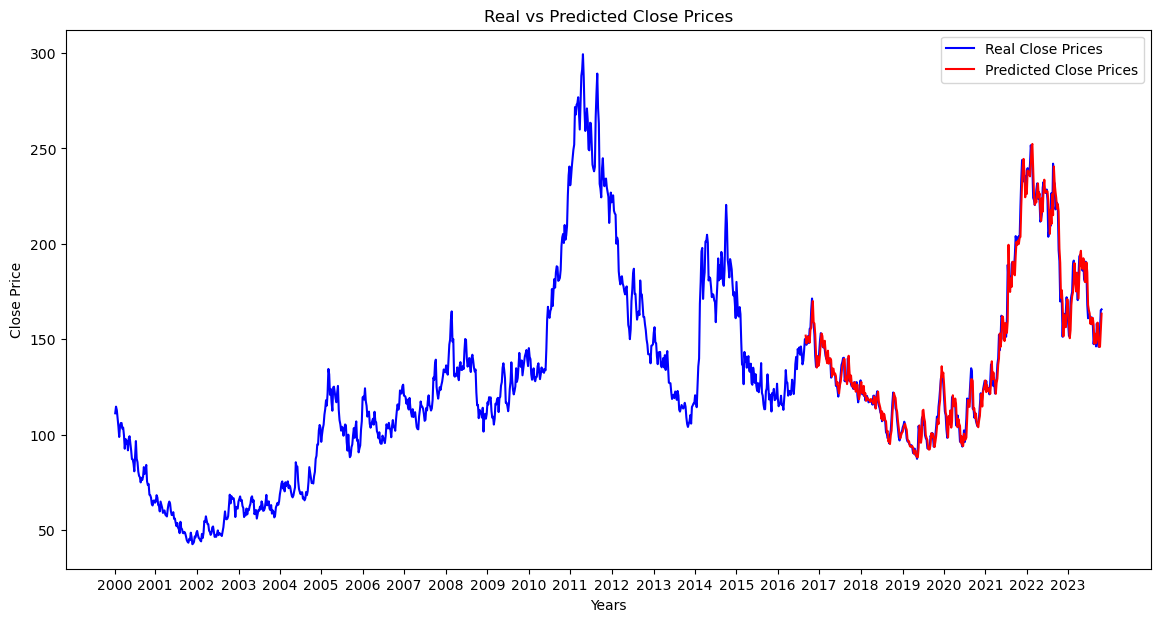

In [8]:
# Almacena y devuelve los precios de cierre reales
actual_close_prices = test_data.loc[:, ["Close"]]

# Convertir 'actual_close_prices' a una lista si es un DataFrame de pandas
if isinstance(actual_close_prices, pd.DataFrame):
    actual_close_prices = actual_close_prices["Close"].tolist()

# Crear el gráfico
plt.figure(figsize=(14, 7))

# Trazar los precios de cierre reales
plt.plot(used_data.loc[:, ["Close"]], label='Real Close Prices', color='blue')

# Trazar los precios de cierre previstos
plt.plot(range(len(train_data), len(train_data) + len(predicted_close_prices)), predicted_close_prices, label='Predicted Close Prices', color='red')

# Añadir título y etiquetas
plt.title('Real vs Predicted Close Prices')
plt.xlabel('Years')
plt.ylabel('Close Price')
plt.legend()

# Configurar las etiquetas de los xticks con los años únicos
plt.xticks(ticks=year_indices, labels=unique_years)

# Mostrar el gráfico
plt.show()

In [9]:
# Error de las predicciones
error_abs = abs(np.array(actual_close_prices) - np.array(predicted_close_prices))/np.array(actual_close_prices) 
error_10days = error_abs.mean()
error_10days

0.032541111404007596

# Buy, Sell and Hold Signals

In [10]:
# Precios de cierre históricos
historical_close_prices = used_data['Close']

# Calcular los cambios fraccionales en los precios de cierre
frac_changes = [(historical_close_prices[i] - historical_close_prices[i-1]) / historical_close_prices[i-1] for i in range(1, len(historical_close_prices))]

# Calcular el promedio y la desviación estándar de los cambios fraacionales
avg_frac_change = np.mean(frac_changes)
std_frac_change = np.std(frac_changes)

# Definir los umbrales de compra y venta basados en el análisis histórico
buy_threshold = avg_frac_change + std_frac_change
sell_threshold = avg_frac_change - std_frac_change

print(buy_threshold, sell_threshold)

0.04459156283439439 -0.042082927191246663


In [11]:
# Inicializar una lista para almacenar las señales
trade_signals = []

# Definir umbrales
buy_threshold = buy_threshold 
sell_threshold = sell_threshold
# Todo lo demás se considerará una señal de retención

# Generar señales de trading
for i in range(1, len(historical_close_prices)):
    real_close_price_prev_day = historical_close_prices[i - 1]
    real_close_price_today = historical_close_prices[i]

    # Calcular el cambio fraccional
    frac_change = (real_close_price_today - real_close_price_prev_day) / real_close_price_prev_day

    # Generar señales de trading
    if frac_change > buy_threshold:
        trade_signals.append('Compra')
    elif frac_change < sell_threshold:
        trade_signals.append('Venta')
    else:
        trade_signals.append('Retención')

# Agregar una señal de 'Retención' para el primer día
trade_signals.insert(0, 'Retención')

In [12]:
# Agregar la columna de señales al dataframe
data_change = used_data.copy()
data_change['Signal'] = trade_signals
data_change.head(500)

,Date,Open,High,Low,Close,Signal
0,2000-01-17,118.250000,118.800003,110.800003,111.199997,Retención
1,2000-01-24,111.000000,116.400002,110.949997,114.699997,Retención
2,2000-01-31,114.000000,114.500000,109.800003,112.900002,Retención
3,2000-02-07,114.000000,114.250000,106.900002,108.800003,Retención
4,2000-02-14,107.000000,107.599998,103.750000,104.300003,Retención
...,...,...,...,...,...,...
495,2009-07-13,111.500000,116.250000,111.500000,116.250000,Retención
496,2009-07-20,118.000000,125.449997,116.349998,123.949997,Compra
497,2009-07-27,124.000000,128.000000,120.300003,127.849998,Retención
498,2009-08-03,128.149994,138.050003,128.050003,137.899994,Compra


In [13]:
# Analizar el rendimiento del modelo
buy_signal = data_change[data_change["Signal"] == "Compra"]
sell_signal = data_change[data_change["Signal"] == "Venta"]

sum1 = 0

for i in buy_signal.index:
    retur = (data_change["Close"][i+1] - data_change["Close"][i])/data_change["Close"][i]
    sum1 += retur

for j in sell_signal.index:
    retur = -(data_change["Close"][i+1] - data_change["Close"][i])/data_change["Close"][i]
    sum1 += retur

sum1

0.9716582149320425

# Prediction

In [14]:
def predict_next_day():
    
    # Usar los días de latencia de la prueba para la predicción
    last_days_data = test_data.iloc[-n_latency_days:]

    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    last_open_price = last_days_data.iloc[-1]["Open"]
    predicted_frac_change, _, _ = most_probable_outcome
    predicted_close_price = last_open_price * (1 + predicted_frac_change)

    return predicted_close_price

# Predecir el precio de cierre del siguiente día
next_day_predicted_price = predict_next_day()
print(f'Predicted closing price for the next day: {next_day_predicted_price}')

Predicted closing price for the next day: 163.399994


In [15]:
# Calcular el cambio fraccional para el siguiente día
predicted_frac_change = (next_day_predicted_price - test_data['Close'].iloc[-1]) / test_data['Close'].iloc[-1]

if predicted_frac_change > buy_threshold:
    trade_signal = 'Compra'
elif predicted_frac_change < sell_threshold:
    trade_signal = 'Venta'
else:
    trade_signal = 'Retención'

print(f'La señal de trading para el valor predicho es: {trade_signal}')

La señal de trading para el valor predicho es: Retención
